<a href="https://colab.research.google.com/github/CIA-Oceanix/DLGD2022/blob/main/lecture-4-dl-oi-da/notebooks/notebookPyTorch_InvProb_ModelBased_L63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook for the implementation of model-based inversion scheme**: Application to the Data Assimilation of Lorenz-63 dynamics given noisy and partial observations.

We consider model-based formulation based on the following variational minimization
$$\arg \min_x \| x - y\|^2_\Omega + \lambda \|x-\Phi(x)\|^2 $$

The notebook addresses two approaches which differ in the considered prior $\Phi$
*   *Weak-Constrained 4DVar formulation* with the true ODE-based prior: Pytorch implementation of the gradient descent. You need to code the computation of the gradient of tha variational cost using automatic differentiation tool.
*   *Exploration of a pretrained plug-and-play prior*: Pytorch gradient descent with a PCA-based prior. You need to compute the loss for such a PCA-based prior. 

*Possible extensions*: (i) evaluation of the reconstruction performance depending on the considered observation setting (i.e., sampling and noise), (ii) intercomparison of different types of plug-and-play


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
from sklearn.feature_extraction import image

# L63 Data simulation

(10000, 3)


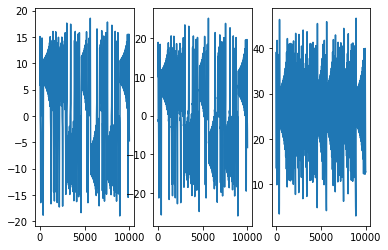

In [3]:
#os.chdir('/content/drive/My Drive/Colab Notebooks/AnDA')
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#from AnDA_codes.AnDA_dynamical_models import AnDA_Lorenz_63, AnDA_Lorenz_96

def AnDA_Lorenz_63(S,t,sigma,rho,beta):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0]);
    x_2 = S[0]*(rho-S[2])-S[1];
    x_3 = S[0]*S[1] - beta*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 10000 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

GD = GD()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(GD.dt_integration,GD.nb_loop_test*GD.dt_integration+0.000001,GD.dt_integration)
#S = odeint(AnDA_Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.01,GD.nb_loop_test+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()

print(S.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(S[:,jj])
  
class time_series:
  values = 0.
  time   = 0.
  
xt = time_series()
xt.values = S
xt.time   = tt

In [4]:
####################################################
## Generation of training and test dataset
## Extraction of time series of dT time steps            
NbTraining = 10000
NbTest     = 2000#256
time_step = 1
dT        = 200
sigNoise  = np.sqrt(2.0)
rateMissingData = (1-1./8.)#(1-1./8.)#0.75#0.95
  
xt = time_series()
xt.values = S
xt.time   = tt
# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:7500:time_step,:],(dT,3),max_patches=NbTraining)
dataTestNoNaN     = image.extract_patches_2d(xt.values[8000::time_step,:],(dT,3),max_patches=NbTest)

# create missing data
flagTypeMissData = 1
if flagTypeMissData == 0:
    print('..... Observation pattern: Random sampling of osberved L63 components')
    indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
    dataTraining[indRand] = float('nan')
    dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))
    
    indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
    dataTest[indRand] = float('nan')
    dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
elif flagTypeMissData == 2:
    print('..... Observation pattern: Only the first L63 component is osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,0] = dataTrainingNoNaN[:,::time_step_obs,0]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,0] = dataTestNoNaN[:,::time_step_obs,0]

    genSuffixObs    = '_ObsDim0_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
   
else:
    print('..... Observation pattern: All  L63 components osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]

    genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    
# set to NaN patch boundaries
dataTraining[:,0:10,:] =  float('nan')
dataTest[:,0:10,:]     =  float('nan')
dataTraining[:,dT-10:dT,:] =  float('nan')
dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

############################################
## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_test         = dataTestNoNaN
X_test_missing = dataTest
mask_test      = maskTest

############################################
## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 
stdTr           = np.sqrt( np.mean( (X_train_missing-meanTr)**2 ) / np.mean(mask_train) )

if flagTypeMissData == 2:
    meanTr          = np.mean(X_train[:]) 
    stdTr           = np.sqrt( np.mean( (X_train-meanTr)**2 ) )

x_train_missing = ( X_train_missing - meanTr ) / stdTr
x_test_missing  = ( X_test_missing - meanTr ) / stdTr

# scale wrt std

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr

print('.... MeanTr = %.3f --- StdTr = %.3f '%(meanTr,stdTr))

# Generate noisy observsation
X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_test_obs  = X_test_missing  + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0],X_test_missing.shape[1],X_test_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTr) / stdTr

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


..... Observation pattern: All  L63 components osberved
.... MeanTr = 8.553 --- StdTr = 27.906 
..... Training dataset: 7301x3x200
..... Test dataset    : 1801x3x200


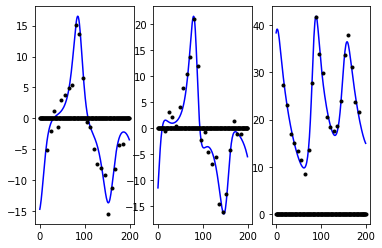

In [4]:
# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(X_train[20,jj,:],'b-')
  plt.plot(X_train_obs[20,jj,:],'k.')

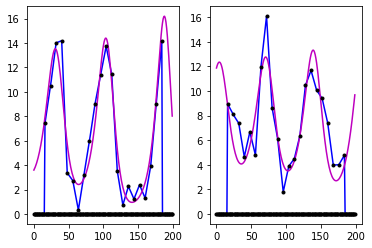

In [5]:
# Initial interpolation (linear interpolation or zeros) for missing data

import scipy

mx_train = np.sum( np.sum( X_train , axis = 2 ) , axis = 0 ) / (X_train.shape[0]*X_train.shape[2])

flagInit = 1

if flagInit == 0: 
  X_train_Init = mask_train * X_train_obs + (1. - mask_train) * (np.zeros(X_train_missing.shape) + meanTr)
  X_test_Init  = mask_test * X_test_obs + (1. - mask_test) * (np.zeros(X_test_missing.shape) + meanTr)
else:
  X_train_Init = np.zeros(X_train.shape)
  for ii in range(0,X_train.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_train.shape[1],X_train.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_train[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_train[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_train_obs[ii,kk,indt])
        XInit[kk,indt]  = X_train_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_train_Init[ii,:,:] = XInit

  X_test_Init = np.zeros(X_test.shape)
  for ii in range(0,X_test.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_test.shape[1],X_test.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_test[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_test[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_test_obs[ii,kk,indt])
        XInit[kk,indt]  = X_test_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_test_Init[ii,:,:] = XInit


x_train_Init = ( X_train_Init - meanTr ) / stdTr
x_test_Init = ( X_test_Init - meanTr ) / stdTr


if 1*1:
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(X_train_Init[20,0,:],'b-')
  plt.plot(X_train[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_train_obs[20,0,:],'k.')
  plt.subplot(1,2,2)
  plt.plot(X_test_Init[20,0,:],'b-')
  plt.plot(X_test[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_test_obs[20,0,:],'k.')

# Explicit Euler ODE scheme in Pytorch



In [7]:
# define forward model (Euler)
class ODE_L63(torch.nn.Module):
    def __init__(self,sigma,rho,beta):
        super(ODE_L63, self).__init__()
        self.sigma = sigma
        self.rho   = rho
        self.beta  = beta

    def forward(self, x):
      x_1 = (self.sigma*(x[:,1]-x[:,0])).view(-1,1)
      x_2 = (x[:,0]*(self.rho-x[:,2])-x[:,1]).view(-1,1)
      x_3 = (x[:,0]*x[:,1] - self.beta*x[:,2]).view(-1,1)

      return torch.cat((x_1,x_2,x_3),dim=1)

    def _euler_update(self,x,dt):
      return x + dt * self.forward(x)

    def _rk4_update(self, x,dt):
        k1 = self.forward(x)
        x2 = x + 0.5 * dt * k1
        k2 = self.forward(x2)
      
        x3 = x + 0.5 * dt * k2
        k3 = self.forward(x3)
          
        x4 = x + dt * k3
        k4 = self.forward(x4)

        return x + dt * (k1+2.*k2+2.*k3+k4)/6.
    def ode_solver_one_step(self, x,dt,solver='rk4'):
        if solver == 'rk4':
          return self._rk4_update(x,dt)
        else:
          return self._euler_update(x,dt)


    def ode_solver_n_steps(self, x,dt,N,solver='rk4'):
      x_ = x 
      x_all = x

      for _ in range(0,N-1):
        x_ = self.ode_solver_one_step(x_,dt)

        x_all = torch.cat((x_all,x_),dim=0)

      return x_all
       


In [25]:
ii = 100

# create torch tensors for observations and hidden states
XGT_torch  = torch.Tensor( X_train[ii,:,:].squeeze().transpose() )
YObs_torch = torch.Tensor( X_train_obs[ii,:,:].squeeze().transpose() )
M_torch    = torch.Tensor( mask_train[ii,:,:].squeeze().transpose() )

# Initialisation
X_torch    = torch.Tensor( X_train_Init[ii,:,:].squeeze().transpose() )

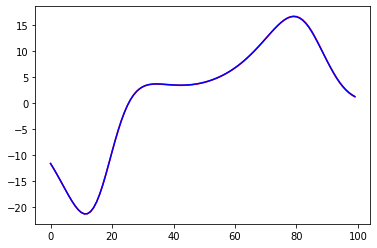

In [9]:
# check model simulation through an Euler integration scheme
ode_L63 = ODE_L63(10.,28.,8./3)

x0 = XGT_torch[0,:]
dt = 0.01
N = 100
solver = 'rk4'#'euler'

Xsim = ode_L63.ode_solver_n_steps(x0.view(-1,3),dt,N,solver=solver)

plt.figure()
plt.plot(Xsim.cpu().detach().numpy()[:,1],'r-')
plt.plot(XGT_torch.cpu().detach().numpy()[0:100,1],'b-')

# (Weak-constrained) 4DVar DA  Pytorch 

In [10]:
# 4DVAR assimilation
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# assignment to GPU
ode_L63 = ODE_L63(10.,28.,8./3)
ode_L63 = ode_L63.to(device)

# assimilation loop
t0    = 0
dt    = 0.01
dT    = X_torch.size(0)
NIter = 20000
alpha_dyn = 1.
alpha_obs = 0.1
alpha_bgd = 0.
delta = 0.2

solver = 'rk4'

X_torch    = torch.Tensor( X_train_Init[ii,:,:].squeeze().transpose() )
X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

def compute_varcost_4DVarWC(x,y,M,xb,dt,alpha_dyn,alpha_obs,alpha_bgd,solver):
  x_pred   = ode_L63.ode_solver_one_step(x,dt,solver)
  loss_dyn = torch.sum((x[1:,:] - x_pred[:-1,:])**2 )
  loss_obs = torch.sum((x - y)**2 * M )
  loss_bgd = torch.sum((x[0,:] - xb)**2 )

  loss_all = alpha_dyn * loss_dyn + alpha_obs * loss_obs + alpha_bgd * loss_bgd

  return loss_all,loss_dyn,loss_obs,loss_bgd

xb = XGT_torch[t0,:]

# 4DVar cost for the true state
loss_gt,loss_dyn_gt,loss_obs_gt,loss_bgd_gt = compute_varcost_4DVarWC(XGT_torch[t0:t0+dT-1,:],
                                                          YObs_torch[t0:t0+dT-1,:],
                                                          M_torch[t0:t0+dT-1,:],
                                                          xb, dt,
                                                          alpha_dyn,alpha_obs,alpha_bgd,solver=solver)

print(".... True state: loss %.3f dyn_loss %.3f obs_loss %.3f bgd_loss %.3f"%(loss_gt,loss_dyn_gt,loss_obs_gt,loss_bgd_gt))  

# gradient descent loop
for iter in range(0,NIter):

  # compute losses
  with torch.set_grad_enabled(True): 
    # 4dVar cost
    loss,loss_dyn,loss_obs,loss_bgd = compute_varcost_4DVarWC(X_torch[t0:t0+dT,:],
                                                              YObs_torch[t0:t0+dT,:],
                                                              M_torch[t0:t0+dT,:],
                                                              xb, dt,
                                                              alpha_dyn,alpha_obs,alpha_bgd,solver=solver)
    if( np.mod(iter,100) == 0 ):
      print(".... iter %d: loss %.3f dyn_loss %.3f obs_loss %.3f bgd_loss %.3f"%(iter,loss,loss_dyn,loss_obs,loss_bgd))  

    # compute gradient w.r.t. X and update X
    loss.backward()
    X_torch = X_torch - delta * X_torch.grad.data
    
    #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
    #X_torch = X_torch - delta * grad_X[0]
 
    X_torch = torch.autograd.Variable(X_torch, requires_grad=True)


.... True state: loss 15.184 dyn_loss 0.025 obs_loss 151.597 bgd_loss 0.000
.... iter 0: loss 2300.312 dyn_loss 2300.312 obs_loss 0.000 bgd_loss 294.526
.... iter 100: loss 81.172 dyn_loss 52.642 obs_loss 285.296 bgd_loss 227.063
.... iter 200: loss 43.649 dyn_loss 23.086 obs_loss 205.632 bgd_loss 155.816
.... iter 300: loss 27.286 dyn_loss 12.140 obs_loss 151.462 bgd_loss 134.133
.... iter 400: loss 19.347 dyn_loss 7.489 obs_loss 118.584 bgd_loss 128.950
.... iter 500: loss 15.216 dyn_loss 5.289 obs_loss 99.270 bgd_loss 128.661
.... iter 600: loss 12.961 dyn_loss 4.158 obs_loss 88.025 bgd_loss 129.476
.... iter 700: loss 11.685 dyn_loss 3.540 obs_loss 81.457 bgd_loss 130.127
.... iter 800: loss 10.943 dyn_loss 3.186 obs_loss 77.573 bgd_loss 130.233
.... iter 900: loss 10.499 dyn_loss 2.977 obs_loss 75.227 bgd_loss 129.732
.... iter 1000: loss 10.226 dyn_loss 2.849 obs_loss 73.769 bgd_loss 128.675
.... iter 1100: loss 10.053 dyn_loss 2.770 obs_loss 72.828 bgd_loss 127.152
.... iter 120

..... Assimilation performance
.. MSE ALL.   : 1.631 / 0.023
.. MSE ObsData: 0.490 / 0.007
.. MSE Interp : 1.772 / 0.025


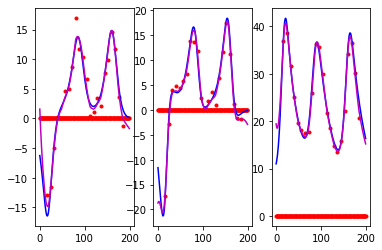

In [11]:
XGT  = XGT_torch.cpu().detach().numpy()[t0:t0+dT,:]
XHat = X_torch.cpu().detach().numpy()[t0:t0+dT,:]
M    = M_torch.cpu().detach().numpy()[t0:t0+dT,:]
YObs = YObs_torch.cpu().detach().numpy()[t0:t0+dT,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(YObs[t0:t0+dT,kk],'r.')
  plt.plot(XGT[:,kk],'b-')
  plt.plot(XHat[:,kk],'m-')

# Reconstruction performance
varXGT  = np.mean( (XGT - np.mean(XGT,axis=0))**2 )
mse_All = np.mean( (XHat-XGT) **2 ) 
mse_I   = np.mean( (1.-M[t0:t0+dT,:]) * (XHat-XGT) **2 ) / np.mean( (1.-M[t0:t0+dT,:]) )
mse_R   = np.mean( M[t0:t0+dT,:] * (XHat-XGT) **2 ) / np.mean( M[t0:t0+dT,:] )

nmse_All = mse_All / varXGT
nmse_I   = mse_I / varXGT
nmse_R   = mse_R / varXGT

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse_All,nmse_All))
print(".. MSE ObsData: %.3f / %.3f"%(mse_R,nmse_R))
print(".. MSE Interp : %.3f / %.3f"%(mse_I,nmse_I))


# Strong-constraint 4DVar DA  Pytorch 

In [56]:
ii = 100

# create torch tensors for observations and hidden states
XGT_torch  = torch.Tensor( X_train[ii,:,:].squeeze().transpose() )
YObs_torch = torch.Tensor( X_train_obs[ii,:,:].squeeze().transpose() )
M_torch    = torch.Tensor( mask_train[ii,:,:].squeeze().transpose() )

# Initialisation
X_torch    = torch.Tensor( X_train_Init[ii,:,:].squeeze().transpose() )

In [57]:
# 4DVAR assimilation
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# assignment to GPU
ode_L63 = ODE_L63(10.,28.,8./3)
ode_L63 = ode_L63.to(device)

# assimilation loop
t0    = 0
dt    = 0.01
dT    = X_torch.size(0)
NIter = 200
alpha_obs = 1e-1
alpha_bgd = 0.
delta = 5e-3

solver = 'rk4'

#X0_torch = torch.autograd.Variable(X_torch[t0,:], requires_grad=True)
bias_init = 0.5 
X0_torch = torch.autograd.Variable( (1.-bias_init) * XGT_torch[t0,:], requires_grad=True)

def compute_varcost_4DVarStrong(x0,y,M,xb,dt,alpha_obs,alpha_bgd,solver):
  x   = ode_L63.ode_solver_n_steps(x0.view(-1,3),dt,y.size(0),solver=solver)

  loss_obs = torch.sum((x - y)**2 * M )
  loss_bgd = torch.sum((x[0,:] - xb)**2 )

  loss_all = alpha_obs * loss_obs + alpha_bgd * loss_bgd

  return loss_all,loss_obs,loss_bgd

bias_bgd = 0.
xb = (1+bias_bgd) * XGT_torch[t0,:]

# 4DVar cost for the true state
loss_gt,loss_obs_gt,loss_bgd_gt = compute_varcost_4DVarStrong(XGT_torch[t0,:],
                                                          YObs_torch[t0:t0+dT,:],
                                                          M_torch[t0:t0+dT,:],
                                                          xb, dt,
                                                          alpha_obs,alpha_bgd,solver=solver)

print(".... True state: loss %.3f obs_loss %.3f bgd_loss %.3f"%(loss_gt,loss_obs_gt,loss_bgd_gt))  

# gradient descent loop
for iter in range(0,NIter):

  # compute losses
  with torch.set_grad_enabled(True): 
    # 4dVar cost
    loss,loss_obs,loss_bgd = compute_varcost_4DVarStrong(X0_torch,
                                                              YObs_torch[t0:t0+dT,:],
                                                              M_torch[t0:t0+dT,:],
                                                              xb, dt,
                                                              alpha_obs,alpha_bgd,solver=solver)
    if( np.mod(iter,5) == 0 ):
      print(".... iter %d: loss %.3f obs_loss %.3f bgd_loss %.3f"%(iter,loss,loss_obs,loss_bgd))  

    # compute gradient w.r.t. X and update X
    loss.backward()
    X0_torch = X0_torch - delta * X0_torch.grad.data
    
    #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
    #X_torch = X_torch - delta * grad_X[0]
 
    X0_torch = torch.autograd.Variable(X0_torch, requires_grad=True)

X_torch = ode_L63.ode_solver_n_steps(X0_torch.view(-1,3),dt,dT,solver=solver)

.... True state: loss 4.034 obs_loss 40.337 bgd_loss 0.000
.... iter 0: loss 149.144 obs_loss 1491.437 bgd_loss 40.440
.... iter 5: loss 146.933 obs_loss 1469.330 bgd_loss 38.133
.... iter 10: loss 145.907 obs_loss 1459.075 bgd_loss 36.216
.... iter 15: loss 144.836 obs_loss 1448.360 bgd_loss 34.332
.... iter 20: loss 143.617 obs_loss 1436.168 bgd_loss 32.402
.... iter 25: loss 142.208 obs_loss 1422.078 bgd_loss 30.402
.... iter 30: loss 140.561 obs_loss 1405.610 bgd_loss 28.319
.... iter 35: loss 138.611 obs_loss 1386.110 bgd_loss 26.143
.... iter 40: loss 136.267 obs_loss 1362.671 bgd_loss 23.865
.... iter 45: loss 133.399 obs_loss 1333.987 bgd_loss 21.473
.... iter 50: loss 129.812 obs_loss 1298.121 bgd_loss 18.959
.... iter 55: loss 125.209 obs_loss 1252.089 bgd_loss 16.313
.... iter 60: loss 119.108 obs_loss 1191.075 bgd_loss 13.530
.... iter 65: loss 110.683 obs_loss 1106.826 bgd_loss 10.618
.... iter 70: loss 98.391 obs_loss 983.906 bgd_loss 7.617
.... iter 75: loss 78.789 obs_l

..... Assimilation performance
.. MSE ALL.   : 0.069 / 0.001
.. MSE ObsData: 0.048 / 0.001
.. MSE Interp : 0.070 / 0.001


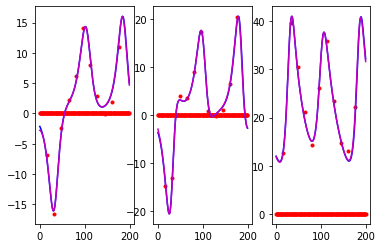

In [58]:
XGT  = XGT_torch.cpu().detach().numpy()[t0:t0+dT,:]
XHat = X_torch.cpu().detach().numpy()[t0:t0+dT,:]
M    = M_torch.cpu().detach().numpy()[t0:t0+dT,:]
YObs = YObs_torch.cpu().detach().numpy()[t0:t0+dT,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(YObs[t0:t0+dT,kk],'r.')
  plt.plot(XGT[:,kk],'b-')
  plt.plot(XHat[:,kk],'m-')

# Reconstruction performance
varXGT  = np.mean( (XGT - np.mean(XGT,axis=0))**2 )
mse_All = np.mean( (XHat-XGT) **2 ) 
mse_I   = np.mean( (1.-M[t0:t0+dT,:]) * (XHat-XGT) **2 ) / np.mean( (1.-M[t0:t0+dT,:]) )
mse_R   = np.mean( M[t0:t0+dT,:] * (XHat-XGT) **2 ) / np.mean( M[t0:t0+dT,:] )

nmse_All = mse_All / varXGT
nmse_I   = mse_I / varXGT
nmse_R   = mse_R / varXGT

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse_All,nmse_All))
print(".. MSE ObsData: %.3f / %.3f"%(mse_R,nmse_R))
print(".. MSE Interp : %.3f / %.3f"%(mse_I,nmse_I))

# Model-based inversion using a trainable plug-and-play prior (PCA prior)

In [34]:
DimAE = 10

In [36]:
# Training a simple auto-encoder
# PCA decomposition
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(X_train,(x_train.shape[0],X_train.shape[1]*X_train.shape[2])))

rec_PCA_Tt       = pca.transform(np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2])))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - X_test.reshape((x_test.shape[0],X_test.shape[1]*X_test.shape[2])))**2 )
var_Tt           = np.mean( (X_test-np.mean(X_train,axis=0))** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(pca.explained_variance_ratio_)[DimAE-1]))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))

shapeData = x_train.shape[1:]

class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = torch.nn.Linear(shapeData[0]*shapeData[1],DimAE,bias=False)
        self.fc1.weight = torch.nn.Parameter( torch.Tensor( pca.components_[0:DimAE,:] ))
        self.mean_ = torch.nn.Parameter( torch.Tensor( pca.mean_ ) )
        
    def forward(self, x):
        x = self.fc1( x.view(-1,shapeData[0]*shapeData[1]) - self.mean_ )
        return x
  
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = torch.nn.Linear(DimAE,shapeData[0]*shapeData[1],bias=False)
        self.fc1.weight = torch.nn.Parameter( torch.Tensor( pca.components_[0:DimAE,:].transpose() ) )
        self.mean_ = torch.nn.Parameter( torch.Tensor( pca.mean_ ) )
    def forward(self, x):
        x = self.fc1( x ) + self.mean_
        x = x.view(-1,shapeData[0],shapeData[1])
        return x

class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE           = Model_AE()
print(model_AE)

.......... PCA Dim = 10
.... explained variance PCA (Tr) : 82.16%
.... explained variance PCA (Tt) : 81.74%
Model_AE(
  (encoder): Encoder(
    (fc1): Linear(in_features=600, out_features=10, bias=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=10, out_features=600, bias=False)
  )
)


In [37]:
ii = 100
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create torch tensors for observations and hidden states
XGT_torch  = torch.Tensor( X_train[ii,:,:].squeeze() ).to(device)
YObs_torch = torch.Tensor( X_train_obs[ii,:,:].squeeze() ).to(device)
M_torch    = torch.Tensor( mask_train[ii,:,:].squeeze() ).to(device)

# Initialisation
X_torch    = torch.Tensor( X_train_Init[ii,:,:].squeeze() ).to(device)

In [38]:
dT = 200

In [39]:
# 4DVAR assimilation

# assignment to GPU
model_AE = model_AE.to(device)

# assimilation loop
t0    = 0
NIter = 10000
alpha_dyn = 1.
alpha_obs = 0.1
alpha_bgd = 0.
delta = 0.2

solver = 'euler'

X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

bias_bgd = 0.
xb = (1+bias_bgd) * XGT_torch[:,0]

def compute_loss(x,y,M,xb,alpha_dyn,alpha_obs,alpha_bgd):
  X_pred = model_AE( torch.reshape(x,(1,-1,dT)) )
  X_pred = torch.reshape(X_pred,(-1,dT))

  loss_dyn = torch.sum((x - X_pred)**2 )

  loss_obs = torch.sum((x - y)**2 * M )
  loss_bgd = torch.sum((x[:,0] - xb)**2 )

  loss_all = alpha_dyn * loss_dyn + alpha_obs * loss_obs + alpha_bgd * loss_bgd

  return loss_all,loss_dyn,loss_obs,loss_bgd

X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

for iter in range(0,NIter):

  # compute losses
  with torch.set_grad_enabled(True): 
    loss, loss_dyn, loss_obs , loss_bgd = compute_loss(X_torch,YObs_torch,M_torch,xb,alpha_dyn,alpha_obs,alpha_bgd)

    if( np.mod(iter,10) == 0 ):
      print(".... iter %d: loss %.3f dyn_loss %.3f obs_loss %.3f"%(iter,loss,loss_dyn,loss_obs))  

    # compute gradient w.r.t. X and update X
    loss.backward()
    #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
    X_torch = X_torch - delta * X_torch.grad.data
    X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

.... iter 0: loss 23537.127 dyn_loss 23537.127 obs_loss 0.000
.... iter 10: loss 106.195 dyn_loss 10.753 obs_loss 954.422
.... iter 20: loss 102.764 dyn_loss 9.108 obs_loss 936.560
.... iter 30: loss 100.361 dyn_loss 8.906 obs_loss 914.550
.... iter 40: loss 98.144 dyn_loss 8.721 obs_loss 894.230
.... iter 50: loss 96.099 dyn_loss 8.551 obs_loss 875.482
.... iter 60: loss 94.212 dyn_loss 8.393 obs_loss 858.185
.... iter 70: loss 92.471 dyn_loss 8.248 obs_loss 842.224
.... iter 80: loss 90.864 dyn_loss 8.115 obs_loss 827.493
.... iter 90: loss 89.381 dyn_loss 7.991 obs_loss 813.898
.... iter 100: loss 88.012 dyn_loss 7.877 obs_loss 801.348
.... iter 110: loss 86.748 dyn_loss 7.771 obs_loss 789.762
.... iter 120: loss 85.581 dyn_loss 7.674 obs_loss 779.064
.... iter 130: loss 84.503 dyn_loss 7.584 obs_loss 769.186
.... iter 140: loss 83.507 dyn_loss 7.501 obs_loss 760.062
.... iter 150: loss 82.588 dyn_loss 7.425 obs_loss 751.635
.... iter 160: loss 81.739 dyn_loss 7.354 obs_loss 743.849

..... Assimilation performance
.. MSE ALL.   : 14.722 / 0.104
.. MSE ObsData: 8.726 / 0.062
.. MSE Interp : 15.463 / 0.110


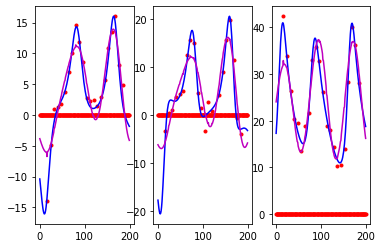

In [40]:
XGT  = XGT_torch.cpu().detach().numpy()[t0:t0+dT,:]
XHat = X_torch.cpu().detach().numpy()[t0:t0+dT,:]
M    = M_torch.cpu().detach().numpy()[t0:t0+dT,:]
YObs = YObs_torch.cpu().detach().numpy()[t0:t0+dT,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(YObs[kk,t0:t0+dT],'r.')
  plt.plot(XGT[kk,:],'b-')
  plt.plot(XHat[kk,:],'m-')

# Reconstruction performance
varXGT  = np.mean( (XGT - np.mean(XGT,axis=0))**2 )
mse_All = np.mean( (XHat-XGT) **2 ) 
mse_I   = np.mean( (1.-M[t0:t0+dT,:]) * (XHat-XGT) **2 ) / np.mean( (1.-M[t0:t0+dT,:]) )
mse_R   = np.mean( M[t0:t0+dT,:] * (XHat-XGT) **2 ) / np.mean( M[t0:t0+dT,:] )

nmse_All = mse_All / varXGT
nmse_I   = mse_I / varXGT
nmse_R   = mse_R / varXGT

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse_All,nmse_All))
print(".. MSE ObsData: %.3f / %.3f"%(mse_R,nmse_R))
print(".. MSE Interp : %.3f / %.3f"%(mse_I,nmse_I))


# Model-based inversion using a trainable plug-and-play prior (ConvAE prior)

In [12]:
import torch.nn as nn
# Training a ConvAE
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(3, 8, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv1d(8, 16, 3, stride=2, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Conv1d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv1d(32, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(11 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)



        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 11 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 11))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(32, 32, 3, 
            stride=2, output_padding=1),
            #nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.ConvTranspose1d(32, 16, 3, 
            stride=2, output_padding=1),
            #nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.ConvTranspose1d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            #nn.BatchNorm1d(8),
            nn.ReLU(True),
            nn.ConvTranspose1d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        #x = torch.sigmoid(x)

        return x[:,:,0:200]

In [22]:
import torch.nn as nn
# Training a ConvAE
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(3, 8, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv1d(8, 16, 3, stride=2, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Conv1d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv1d(32, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(11 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)



        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 200),
#            nn.Linear(32, 32 * 25),
        )

        #self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 25))
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(3, 200))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.ConvTranspose1d(16, 8, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(True),
            nn.ConvTranspose1d(8, 3, 3, 
            stride=2, output_padding=1),
            #nn.BatchNorm1d(32),
            #nn.ReLU(True),
            #nn.ConvTranspose1d(32, 16, 3, 
            #stride=2, output_padding=1),
            #nn.BatchNorm1d(16),
            #nn.ReLU(True),
            #nn.ConvTranspose1d(16, 8, 3, stride=2, 
            #padding=1, output_padding=1),
            #nn.BatchNorm1d(8),
            #nn.ReLU(True),
            #nn.ConvTranspose1d(8, 1, 3, stride=2, 
            #padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        #x = self.decoder_conv(x)
        
        return x[:,:,0:200]

In [46]:
import torch.nn as nn
# Training a ConvAE
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(3, 8, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv1d(8, 16, 3, stride=2, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Conv1d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Conv1d(32, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(11 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)



        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
#            nn.Linear(32, 3 * 200),
            nn.Linear(32, 16 * 25),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 25))
        #self.unflatten = nn.Unflatten(dim=1, unflattened_size=(3, 200))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(16, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.ConvTranspose1d(16, 8, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(True),
            nn.ConvTranspose1d(8, 3, 3, 
            stride=2, output_padding=1),
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        return x[:,:,0:200]

In [8]:
pip install pytorch_lightning==1.6.5 -q

In [47]:
DimAE = 5

import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

class LitAE(pl.LightningModule): # TODO 1
    def __init__(self):
        super().__init__()

        self.dim_ae = DimAE
        self.encoder = Encoder(encoded_space_dim=self.dim_ae)
        self.decoder = Decoder(encoded_space_dim=self.dim_ae)

        self.test_data = None

    def criterion(self,out,ref):
       return torch.mean( (out - ref)**2 )

    def forward(self,x): 

        out = self.encoder(x.float())
        out = self.decoder(out)

        return out
    
    def training_step(self, batch, batch_idx): ## TODO 1
        data = batch
        output = self(data)
        loss = self.criterion(output , data  )
        self.log('train_loss', loss) ## TODO 3
        return loss
    
    def validation_step(self, batch, batch_idx): ## TODO 1
        data = batch
        output = self(data)
        loss = self.criterion(output, data)
        self.log('val_loss', loss) ## TODO 3
        return loss
  
    def configure_optimizers(self): ## TODO 1
        #return torch.optim.SGD(self.parameters(),lr = 0.001, weight_decay=1e-05) 
        return torch.optim.Adam(self.parameters(),lr = 0.01, weight_decay=1e-05) 

    def test_step(self, batch, batch_idx): ## TODO 5
        data = batch.float()
        output = self(data)
        latent = self.encoder(data)

        loss = self.criterion(output, data)
        self.log('test_loss', loss)

        preds = output.cpu()
        return data.cpu(), preds, latent.cpu()

    def test_epoch_end(self, test_step_outputs): ## TODO 5
        list_of_data, list_of_preds,list_of_latent = zip(*test_step_outputs)
        data, preds,latents = torch.cat(list_of_data),  torch.cat(list_of_preds),  torch.cat(list_of_latent)
        
        self.test_data = data.numpy(), preds.numpy(), latents.numpy()


In [25]:
model = LitAE()

model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss') # TODO 4
logger = pl.loggers.CSVLogger('logs', name='mlp_mnist') 
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=30,
    callbacks=[model_checkpoint], # TODO 4
    logger=logger
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [26]:
batch_size = 64

indperm = np.random.permutation( x_train.shape[0])
m = int(0.75 * x_train.shape[0])

dataloaders = {
    'train': torch.utils.data.DataLoader(x_train[indperm[0:m],:,:], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(x_train[indperm[m:],:,:], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'test': torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory logs/mlp_mnist/version_14/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 16.6 K
1 | decoder | Decoder | 14.7 K
------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Logs stored at logs/mlp_mnist/version_14/metrics.csv


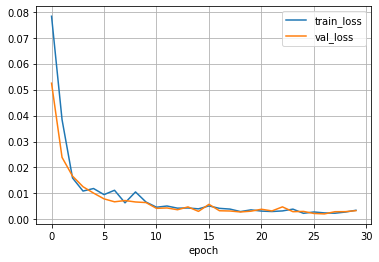

In [52]:
import pandas as pd 

trainer.fit(model, train_dataloaders=dataloaders['train'], val_dataloaders=dataloaders['val'])
print(f"Logs stored at {logger.log_dir}/metrics.csv")


## Plot metrics
(
    pd.read_csv(f'{logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['train_loss', 'val_loss']].plot(grid=True)
)

In [53]:
print(f"""
    Best model saved at {model_checkpoint.best_model_path}
    With validation loss {model_checkpoint.best_model_score}
""")

# Loading best model
best_model = LitAE.load_from_checkpoint(model_checkpoint.best_model_path)
best_model.to(device)


    Best model saved at logs/mlp_mnist/version_14/checkpoints/epoch=26-step=2322.ckpt
    With validation loss 0.00211966317798667



LitAE(
  (encoder): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv1d(3, 8, kernel_size=(3,), stride=(2,))
      (1): ReLU(inplace=True)
      (2): Conv1d(8, 16, kernel_size=(3,), stride=(2,))
      (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv1d(16, 32, kernel_size=(3,), stride=(2,))
      (6): ReLU(inplace=True)
      (7): Conv1d(32, 32, kernel_size=(3,), stride=(2,))
      (8): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=352, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=5, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=400, bias=True)
    )
    (unflatten): Unflatten(dim=1, unflatte

In [54]:
### Explained variance for the convolutional auto-encoder
trainer.test(best_model, dataloaders=dataloaders['test'])

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0032729448284953833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0032729448284953833}]

In [55]:
### Explained variance for the convolutional auto-encoder
x_in,x_ae, x_latent = best_model.test_data

# denormalization
#out_ae = 255 * out_ae
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
out_pca = pca.inverse_transform( pca.transform( x_in.reshape((-1,3*200)) ) )
out_pca = out_pca.reshape((-1,3,200))
mse_convae = np.mean( ( x_ae - x_in)**2 )
mse_pca = np.mean( (out_pca - x_in)**2 )

var_exp_ae = 1. - mse_convae / np.var( x_in )
var_exp_pca = 1. - mse_pca / np.var( x_in )

print('....... Explained variance for test dataset ' )
print('... PCA (%d) = %.3f'%(DimAE,100. * var_exp_pca))
print('... AE (%d) = %.3f'%(model.dim_ae,100. * var_exp_ae))

....... Explained variance for test dataset 
... PCA (5) = 84.679
... AE (5) = 98.503


In [56]:
ii = 100

# create torch tensors for observations and hidden states
XGT_torch  = torch.Tensor( X_train[ii,:,:].squeeze().transpose() )
YObs_torch = torch.Tensor( X_train_obs[ii,:,:].squeeze().transpose() )
M_torch    = torch.Tensor( mask_train[ii,:,:].squeeze().transpose() )

# Initialisation
X_torch    = torch.Tensor( X_train_Init[ii,:,:].squeeze().transpose() )

In [57]:
# 4DVAR assimilation

# assignment to GPU
#model_AE = model_AE.to(device)

# assimilation loop
t0    = 0
NIter = 5000
alpha_dyn = 1.
alpha_obs = 0.1
alpha_bgd = 0.
delta = 0.1

solver = 'euler'

X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

bias_bgd = 0.
xb = (1+bias_bgd) * XGT_torch[0,:]

def compute_loss(x,y,M,xb,alpha_dyn,alpha_obs,alpha_bgd):

  x_ae = torch.reshape(x.transpose(0,1),(1,-1,dT))
  #print( x_ae.size() )
  x_ae = ( x_ae - meanTr ) / stdTr
  X_pred = stdTr * best_model( x_ae ) + meanTr
  #X_pred = model_AE( torch.reshape(x,(1,-1,dT)) )

  X_pred = torch.reshape(X_pred,(-1,dT)).transpose(0,1)

  #print( X_pred.size() )

  loss_dyn = torch.sum((x - X_pred)**2 )

  loss_obs = torch.sum((x - y)**2 * M )
  loss_bgd = torch.sum((x[0,:] - xb)**2 )

  loss_all = alpha_dyn * loss_dyn + alpha_obs * loss_obs + alpha_bgd * loss_bgd

  return loss_all,loss_dyn,loss_obs,loss_bgd

X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

for iter in range(0,NIter):

  # compute losses
  with torch.set_grad_enabled(True): 

    if 1*1 :
      loss, loss_dyn, loss_obs , loss_bgd = compute_loss(X_torch,YObs_torch,M_torch,
                                                         xb,alpha_dyn,alpha_obs,alpha_bgd)
    else:
      # dynamical loss
      X_pred = model_AE( torch.reshape(X_torch,(1,-1,dT)) )
      X_pred = torch.reshape(X_pred,(-1,dT))
      loss_dyn = torch.sum((X_torch - X_pred)**2 )

      # observation loss
      loss_obs = torch.sum((X_torch - YObs_torch)**2 * M_torch )

      loss_bgd = torch.sum((X_torch[:,0] - xb)**2 )

      # overall loss
      loss = alpha_dyn * loss_dyn + alpha_obs * loss_obs + alpha_bgd * loss_bgd

    if( np.mod(iter,10) == 0 ):
      print(".... iter %d: loss %.3f dyn_loss %.3f obs_loss %.3f"%(iter,loss,loss_dyn,loss_obs))  

    # compute gradient w.r.t. X and update X
    loss.backward()
    #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
    X_torch = X_torch - delta * X_torch.grad.data
    X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

.... iter 0: loss 61014.953 dyn_loss 61014.953 obs_loss 0.000
.... iter 10: loss 4204.611 dyn_loss 3571.989 obs_loss 6326.227
.... iter 20: loss 9991.214 dyn_loss 9453.126 obs_loss 5380.879
.... iter 30: loss 2785.141 dyn_loss 2266.890 obs_loss 5182.504
.... iter 40: loss 4078.139 dyn_loss 3628.360 obs_loss 4497.796
.... iter 50: loss 2745.865 dyn_loss 2332.540 obs_loss 4133.242
.... iter 60: loss 3560.446 dyn_loss 3150.541 obs_loss 4099.042
.... iter 70: loss 2587.077 dyn_loss 2198.808 obs_loss 3882.686
.... iter 80: loss 2205.078 dyn_loss 1830.212 obs_loss 3748.660
.... iter 90: loss 2124.939 dyn_loss 1769.371 obs_loss 3555.684
.... iter 100: loss 1900.775 dyn_loss 1568.408 obs_loss 3323.664
.... iter 110: loss 1590.144 dyn_loss 1269.305 obs_loss 3208.388
.... iter 120: loss 1497.675 dyn_loss 1186.055 obs_loss 3116.200
.... iter 130: loss 1355.113 dyn_loss 1055.188 obs_loss 2999.251
.... iter 140: loss 1156.780 dyn_loss 881.377 obs_loss 2754.031
.... iter 150: loss 857.313 dyn_loss 6

..... Assimilation performance
.. MSE ALL.   : 11.241 / 0.155
.. MSE ObsData: 6.713 / 0.092
.. MSE Interp : 11.801 / 0.162


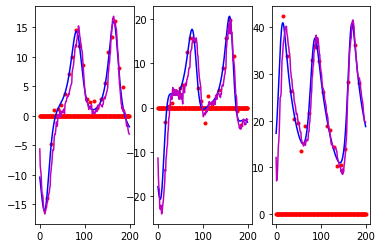

In [58]:
XGT  = XGT_torch.cpu().detach().numpy()[t0:t0+dT,:]
XHat = X_torch.cpu().detach().numpy()[t0:t0+dT,:]
M    = M_torch.cpu().detach().numpy()[t0:t0+dT,:]
YObs = YObs_torch.cpu().detach().numpy()[t0:t0+dT,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(YObs[t0:t0+dT,kk],'r.')
  plt.plot(XGT[:,kk],'b-')
  plt.plot(XHat[:,kk],'m-')

# Reconstruction performance
varXGT  = np.mean( (XGT - np.mean(XGT,axis=0))**2 )
mse_All = np.mean( (XHat-XGT) **2 ) 
mse_I   = np.mean( (1.-M[t0:t0+dT,:]) * (XHat-XGT) **2 ) / np.mean( (1.-M[t0:t0+dT,:]) )
mse_R   = np.mean( M[t0:t0+dT,:] * (XHat-XGT) **2 ) / np.mean( M[t0:t0+dT,:] )

nmse_All = mse_All / varXGT
nmse_I   = mse_I / varXGT
nmse_R   = mse_R / varXGT

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse_All,nmse_All))
print(".. MSE ObsData: %.3f / %.3f"%(mse_R,nmse_R))
print(".. MSE Interp : %.3f / %.3f"%(mse_I,nmse_I))

In [61]:
# 4DVAR assimilation

# assignment to GPU
#model_AE = model_AE.to(device)

# assimilation loop
t0    = 0
NIter = 400
alpha_dyn = 1.
alpha_obs = 0.1
alpha_bgd = 0.
delta = 0.1

# initial latent code
X_torch    = torch.Tensor( X_train_Init[ii,:,:].squeeze().transpose() )
Z_torch = torch.reshape(X_torch.transpose(0,1),(1,-1,dT))
Z_torch = best_model.encoder( ( Z_torch - meanTr ) / stdTr )
Z_torch = torch.autograd.Variable(Z_torch, requires_grad=True)

bias_bgd = 0.
xb = (1+bias_bgd) * XGT_torch[0,:]

def compute_loss(z,y,M,xb,alpha_dyn,alpha_obs,alpha_bgd):
  X_pred = stdTr * best_model.decoder( z ) + meanTr
  #X_pred = model_AE( torch.reshape(x,(1,-1,dT)) )

  X_pred = torch.reshape(X_pred,(-1,dT)).transpose(0,1)

  loss_obs = torch.sum((X_pred - y)**2 * M )
  loss_bgd = torch.sum((X_pred[0,:] - xb)**2 )

  loss_all = alpha_obs * loss_obs + alpha_bgd * loss_bgd

  return loss_all,loss_dyn,loss_obs,loss_bgd

X_torch = torch.autograd.Variable(X_torch, requires_grad=True)

for iter in range(0,NIter):

  # compute losses
  with torch.set_grad_enabled(True): 
    loss, loss_dyn, loss_obs , loss_bgd = compute_loss(Z_torch,YObs_torch,M_torch,
                                                         xb,alpha_dyn,alpha_obs,alpha_bgd)

    if( np.mod(iter,10) == 0 ):
      print(".... iter %d: loss %.3f obs_loss %.3f"%(iter,loss,loss_obs))  

    # compute gradient w.r.t. X and update X
    loss.backward()
    #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
    Z_torch = Z_torch - delta * Z_torch.grad.data
    Z_torch = torch.autograd.Variable(Z_torch, requires_grad=True)

X_torch = stdTr * best_model.decoder( Z_torch ) + meanTr
X_torch = X_torch.transpose(1,2)

.... iter 0: loss 466.773 obs_loss 4667.733
.... iter 10: loss 718.177 obs_loss 7181.771
.... iter 20: loss 403.146 obs_loss 4031.458
.... iter 30: loss 194.902 obs_loss 1949.016
.... iter 40: loss 98.998 obs_loss 989.984
.... iter 50: loss 79.173 obs_loss 791.725
.... iter 60: loss 68.253 obs_loss 682.533
.... iter 70: loss 59.317 obs_loss 593.172
.... iter 80: loss 53.725 obs_loss 537.254
.... iter 90: loss 49.478 obs_loss 494.778
.... iter 100: loss 45.517 obs_loss 455.166
.... iter 110: loss 42.937 obs_loss 429.371
.... iter 120: loss 41.056 obs_loss 410.555
.... iter 130: loss 40.083 obs_loss 400.826
.... iter 140: loss 39.416 obs_loss 394.162
.... iter 150: loss 38.920 obs_loss 389.203
.... iter 160: loss 38.013 obs_loss 380.129
.... iter 170: loss 37.173 obs_loss 371.729
.... iter 180: loss 36.749 obs_loss 367.493
.... iter 190: loss 36.493 obs_loss 364.929
.... iter 200: loss 36.336 obs_loss 363.363
.... iter 210: loss 36.226 obs_loss 362.263
.... iter 220: loss 36.146 obs_loss

..... Assimilation performance
.. MSE ALL.   : 3.863 / 0.053
.. MSE ObsData: 2.934 / 0.040
.. MSE Interp : 3.978 / 0.055


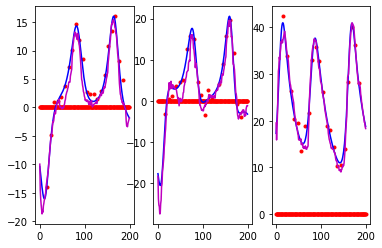

In [62]:
XGT  = XGT_torch.cpu().detach().numpy().squeeze() 
XHat = X_torch.cpu().detach().numpy().squeeze()
M    = M_torch.cpu().detach().numpy().squeeze()
YObs = YObs_torch.cpu().detach().numpy().squeeze()

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(YObs[t0:t0+dT,kk],'r.')
  plt.plot(XGT[:,kk],'b-')
  plt.plot(XHat[:,kk],'m-')

# Reconstruction performance
varXGT  = np.mean( (XGT - np.mean(XGT,axis=0))**2 )
mse_All = np.mean( (XHat-XGT) **2 ) 
mse_I   = np.mean( (1.-M[t0:t0+dT,:]) * (XHat-XGT) **2 ) / np.mean( (1.-M[t0:t0+dT,:]) )
mse_R   = np.mean( M[t0:t0+dT,:] * (XHat-XGT) **2 ) / np.mean( M[t0:t0+dT,:] )

nmse_All = mse_All / varXGT
nmse_I   = mse_I / varXGT
nmse_R   = mse_R / varXGT

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse_All,nmse_All))
print(".. MSE ObsData: %.3f / %.3f"%(mse_R,nmse_R))
print(".. MSE Interp : %.3f / %.3f"%(mse_I,nmse_I))